# Model result viewing

In [1]:
import tensorflow as tf
from time import gmtime, strftime
import time
import datetime
import numpy as np
import math
import copy
import pandas as pd

from attention_model import AttentionModel, set_decode_type
from reinforce_baseline import RolloutBaseline
from train import train_model
from reinforce_baseline import load_tf_model

from generate_data import create_data_on_disk, get_cur_time

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


Current decode type: greedy
Time for execution:  0.89 sec
Travel Cost:  [337.84875849]
Trajectory:  [ 0  7  7  8  8  8  3  3  0  6  6  6 14 14 14  0 11 11 11  2  1  0 13 13
 13  4 12 12 12  0 15 15 15 10  5  5  9  0]
Missed packages:  0 / 32


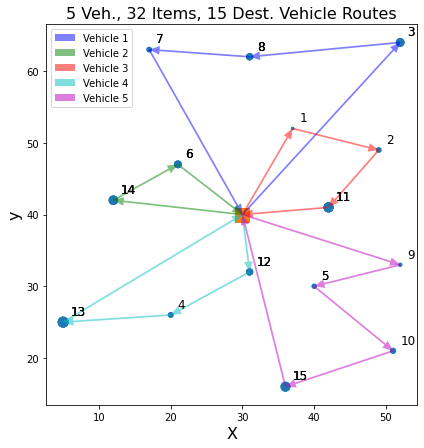

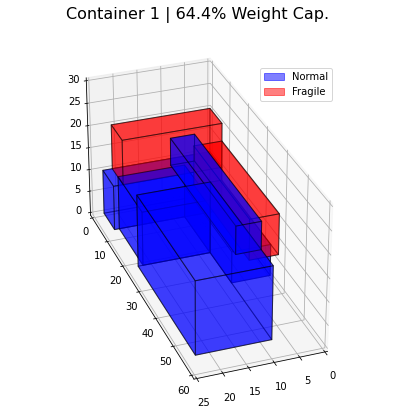

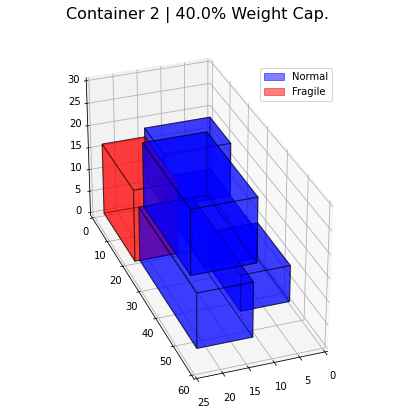

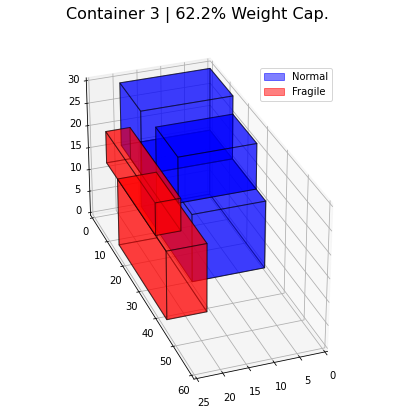

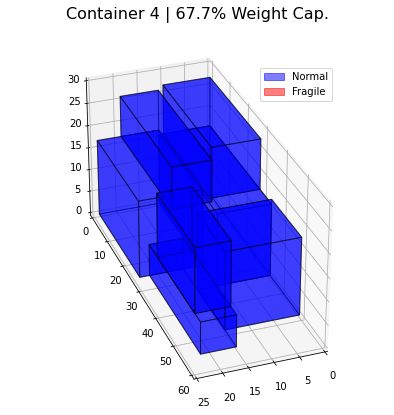

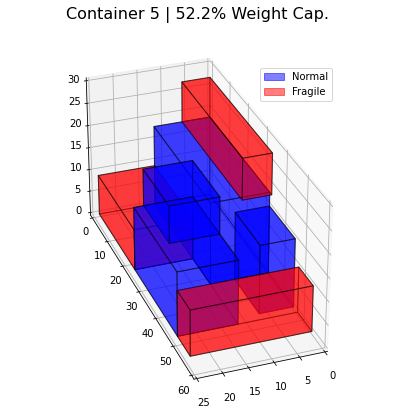

CPU times: user 5.19 s, sys: 1.21 s, total: 6.39 s
Wall time: 3.63 s


array([[ 0, 27, 28, 31, 29, 30, 19, 20,  0, 26, 25, 24, 12, 14, 13,  0,
         3,  5,  4, 18,  1,  0, 11, 10,  9, 21,  7,  6,  8,  0, 16, 17,
        15,  2, 23, 22, 32,  0]])

In [147]:
%%time

select_seed = 5

if select_seed == 51:
    model_name = "EULER__nomix_fulldemand__hwl_6512_seed_51_2021-08-30-05-18_graph15_batch128_lr0.0001"
    epoch = 6000
elif select_seed == 5:
    model_name = "EULER__novehpen_noforce__hwl_6512_seed_5_2021-09-11-08-43_graph15_batch100_lr0.0001"
    epoch = 8200
elif select_seed == 1:
    model_name = "EULER__novehpen_noforce__hwl_6512_seed_1_2021-09-11-08-43_graph15_batch100_lr0.0001"
    epoch = 7700
elif select_seed == 7:
    model_name = "EULER__novehpen_noforce__hwl_6512_seed_7_2021-09-11-08-43_graph15_batch100_lr0.0001"
    epoch = 8500



batches = 1
customers = 5
gendreau = None 
gendreau = 1
seed = None
hwl = [6,5,12]
#hwl = [30,25,60]
# ------------------------
# loading a specific model


load_model = model_name +"_model_checkpoint_epoch_"+str(epoch)+".h5"
model_name = str(load_model)
model_t = load_tf_model("src/checkpoints/"+model_name,
                 embedding_dim=128,
                 graph_size=3)


from reinforce_baseline import load_tf_model
from envs.Environment import TDCVRP
import numpy as np

env = TDCVRP(customers, batches, gendreau =gendreau, seed = seed, hwl = hwl)

# Rotate env (must stay within [0, 100])

#flip x
if False:
    x = copy.deepcopy(env.state[:, :, 1])
    dep_x = env.state[:, 0, 1]
    env.state[:, 1:, 1] = - env.state[:, 1:, 1] + 2* dep_x
    
#flip y
if False:
    x = copy.deepcopy(env.state[:, :, 2])
    dep_x = env.state[:, 0, 2]
    env.state[:, 1:, 2] = - env.state[:, 1:, 2] + 2* dep_x

# translate x,y
if False:
    env.state[:, :, 1] = env.state[:, :, 1] + 20
    env.state[:, :, 2] = env.state[:, :, 2] + 20
    
# rotate i* 90 deg:
rots = 0
if True:
    for i in range(rots):
        x = copy.deepcopy(env.state[:, :, 1])
        y = copy.deepcopy(env.state[:, :, 2])
        env.state[:, :, 1] = y
        env.state[:, :, 2] = 100 - x

sp_env_copy = copy.deepcopy(env)
#env.state[:, :, 3:6] = 1


print("Current decode type: {}".format(model_t.decode_type))

t = time.time()
while not env.all_finished():
    _,_,env = model_t(env, usage = True) # Change to greedy for usage

delta_t = np.round((time.time() - t), 2)

print("Time for execution: ", delta_t, "sec")    
print("Travel Cost: ", env.travel_cost)
print("Trajectory: ", env.clean_trajectory[0])
print("Missed packages: ", np.sum(env.state[0, :, 16] == 0),"/", np.sum(env.state[0, 1:, 16] >= 0 ))
for row in range(env.state.shape[1]):
    if env.state[0, row, 16] == 0:
        print(env.state[0, row, 0:7],env.state[0, row, 26])
env.disp_batch(batch = 0, truck = 0)
env.pandas_state(0)

env.clean_action_list

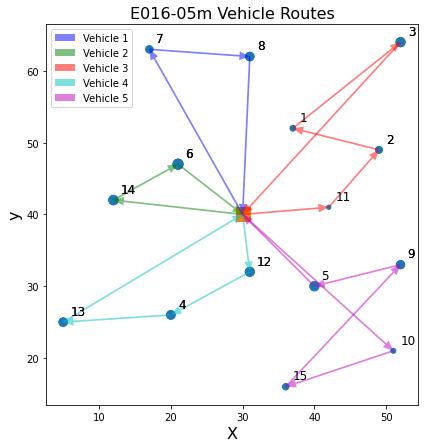

In [102]:
if gendreau == 1:
    fig_name = "E016-03m"
elif gendreau == 2:
    fig_name = "E016-05m"
else:
    fig_name = "undefined"
    
_ = env.render_vrp(
    batch_nr = 0
    , fig_name=fig_name, 
    save_plt=True, 
    show_plt=True,
    )

In [ ]:
_ = env.render_container(
        batch = 0,
        n_container = 0,
        fig_name=fig_name,
        save_plt=True,
        show_plt=True,
    )

In [149]:
#env.make_gif(batch=0, my_title="Gendreau Instance #1", fps = 3)

In [ ]:
env.pandas_state(0).sort_values(by=['seq_nr']).head()

In [ ]:
def get_sp(sp_env_copy):
    sp_env = copy.deepcopy(sp_env_copy)
    sp_cost = 0
    while sp_env.all_finished() is False:
        sp_dist = sp_env.state[:, :, 14] + (sp_env.get_mask()[:, 0, :] * 9999)
        sp_dist[:, 0] = 999  # discourage depot trip
        sp_dists = sp_dist  #  np.concatenate((sp_dist, sp_dist), axis=1)
        sp_acts = np.zeros([sp_env.state.shape[0], sp_env.state.shape[1]])
        for batch in range(sp_env.state.shape[0]):

            sp_acts[batch] = [
                x
                for _, x in sorted(
                    zip(sp_dists[batch], np.arange(sp_env.state.shape[1]),),
                    reverse=False,
                )
            ]
        print(sp_acts)
        sp_env.step(sp_acts)
        sp_cost = sp_env.get_distance()

    env = sp_env
    print("Travel Cost: ", env.travel_cost)
    print("Trajectory: ", env.clean_trajectory[0])
    print("Missed packages: ", np.sum(env.state[0, :, 16] == 0),"/", np.sum(env.state[0, 1:, 16] >= 0 ))
    for row in range(env.state.shape[1]):
        if env.state[0, row, 16] == 0:
            print(env.state[0, row, 0:7],env.state[0, row, 26])
    env.disp_batch(batch = 0, truck = 0)
    env.pandas_state(0)
    print(env.clean_action_list)

In [ ]:
# Model performance table


model_list = list()

model_list.append("EULER__nomix__hwl_6512_seed_1_2021-08-26-13-09_graph15_batch128_lr0.0001_model_checkpoint_epoch_3600.h5")
model_list.append("EULER__nomix__hwl_6512_seed_7_2021-08-26-13-09_graph15_batch128_lr0.0001_model_checkpoint_epoch_2100.h5")
model_list.append("EULER__nomix__hwl_6512_seed_51_2021-08-26-13-09_graph15_batch128_lr0.0001_model_checkpoint_epoch_2500.h5")
model_list.append("EULER__nomix_v3__hwl_6512_seed_1_2021-08-27-17-11_graph15_batch128_lr0.0001_model_checkpoint_epoch_1200.h5")
model_list.append("EULER__nomix_v3__hwl_6512_seed_7_2021-08-27-17-11_graph15_batch128_lr0.0001_model_checkpoint_epoch_1100.h5")
model_list.append("EULER__nomix_v3__hwl_6512_seed_51_2021-08-27-17-11_graph15_batch128_lr0.0001_model_checkpoint_epoch_1100.h5")
model_runs = pd.DataFrame(np.zeros([len(model_list),5]), columns = ["Model", "Gendreau 1", "Gendreau 2", "Delta 1", "Delta 2"])
row = 0
for model_name in model_list:

    customers = 15
    
    seed = None
    hwl = [6,5,12]

    model_t = load_tf_model("src/checkpoints/"+model_name,
                     embedding_dim=128,
                     graph_size=3)
    gendreau = 1
    env = TDCVRP(customers, 1, gendreau =gendreau, seed = seed, hwl = hwl) 
    gendreau = 2
    env2 = TDCVRP(customers, 1, gendreau =gendreau, seed = seed, hwl = hwl) 

    while not env.all_finished():
        _,_,env = model_t(env, usage = True) # Change to greedy for usage
    while not env2.all_finished():
        _,_,env2 = model_t(env2, usage = True) # Change to greedy for usage

    model_runs.iloc[row, 0] = model_name
    model_runs.iloc[row, 1] = np.round(env.travel_cost[0], 1)
    model_runs.iloc[row, 2] = np.round(env2.travel_cost[0], 1)
    model_runs.iloc[row, 3] = 1/316.32 * np.round(env.travel_cost[0], 1)
    model_runs.iloc[row, 4] = 1/350.58 * np.round(env2.travel_cost[0], 1)
    
    row += 1


In [ ]:
model_runs.style.set_properties(subset=['Model'], **{'width': '500px'})

## Compute time

In [50]:
# https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [51]:
model_name = "EULER__nomix_fulldemand__hwl_6512_seed_51_2021-08-30-05-18_graph15_batch128_lr0.0001"
epoch = 6000
batches = 1
gendreau = None 
seed = None
hwl = [30,25,60] #

load_model = model_name +"_model_checkpoint_epoch_"+str(epoch)+".h5"
model_name = str(load_model)
model_t = load_tf_model("src/checkpoints/"+model_name,
                 embedding_dim=128,
                 graph_size=3)


iterations = 1
max_dest = 100

time_table = np.zeros([(max_dest+1)* iterations,4])
for customers in range(max_dest):
    if customers % 10 == 0:
        print(customers)
    customers = customers + 1
    #time_list = list()
    for i in range(iterations):
        env = TDCVRP(customers, batches, gendreau =gendreau, seed = seed, hwl = hwl) 
        t = time.time()
        while not env.all_finished():
            _,_,env = model_t(env, usage = True) # Change to greedy for usage

        delta_t = np.round((time.time() - t), 3)
        #time_list.append(delta_t)
        #m, m_min, m_max = mean_confidence_interval(time_list)
        time_table[customers * iterations + i, 0] = customers
        time_table[customers * iterations + i, 1] = delta_t
        #time_table[customers * iterations + i, 2] = m_min
        #time_table[customers * iterations + i, 3] = m_max

time_table = time_table[1:]
#time_table

0
10


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import r2_score
fig, ax = plt.subplots()


ax.scatter(time_table[:,0],time_table[:,1], label='Our Model')
#ax.fill_between(time_table[:,0], time_table[:,2], time_table[:,3], color='b', alpha=.1)

z = np.polyfit(time_table[:,0], time_table[:,1], 1)
p = np.poly1d(z)
plt.plot(time_table[:,0],p(time_table[:,0]),"k--")
plt.title("y=%.6fx+%.6f"%(z[0],z[1]))


r2 = r2_score(time_table[:,1], p(time_table[:,0]))

# patch = mpatches.Patch(color=(0,0,1,0.2), label="95% Confidence Interval")
          

#plt.legend(
#    handles=[patch],
#    loc="upper left",
#    bbox_to_anchor=(0.05, 0.95),
#)

plt.title("Compute time scaling with destinations (n)")
plt.xlabel("Customer destinations (n)")
plt.ylabel("Avg. compute time [sec]")
plt.annotate("R^2 = {:.2f}".format(np.round(r2,2)), (80,20))
ax.set_yscale('log')
ax.set_xscale('log')

cg = [19.73, 5.69, 36.48, 12.44, 38.17, 18.65, 47.50, 42.79, 35.24, 128.18, 156.18, 70.07, 185.79, 295.60, 330.06, 98.12, 84.05, 606.64, 1280.08, 1464.27, 1700.46, 1180.41, 1353.24, 1089.99, 2435.53, 2815.44, 3553.39]
cg_n = [15,15,20,20,21,21,22,22,25,29,29,30,32,32,32,35,40,44,50,71,75,75,75,75,100,100,100]

cg = np.array(cg)
cg_n = np.array(cg_n)

lowess_model = lowess.Lowess()
lowess_model.fit(cg_n, cg)
x_pred = np.linspace(15, 100, 100)
y_pred = lowess_model.predict(x_pred)

ax.scatter(cg_n,cg, label='Mahvash et al. (2017)')

z = np.polyfit(cg_n, cg, 1)
p = np.poly1d(z)
#plt.plot(cg_n,p(cg_n),"k--", label = "xx")
#plt.title("y=%.6fx+%.6f"%(z[0],z[1]))

r2 = r2_score(time_table[:,1], p(time_table[:,0]))

#plt.plot(x_pred, y_pred, '--', label='LOWESS', color='black', zorder=5)
plt.title("Compute time scaling with destinations (n)")
plt.xlabel("Customer destinations (n)")
plt.ylabel("Avg. compute time [sec]")

plt.xlim(left=14)
plt.xlim(right=120) 
plt.ylim(bottom=0.5) 


x = np.linspace(0,110,1000) + 14
plt.plot(x,0.07*x, color = "grey", linewidth = 0.5, label = "k*x (linear scaling)")
plt.plot(x,0.7*x, color = "grey", linewidth = 0.5)
plt.plot(x,7*x, color = "grey", linewidth = 0.5)

x = np.linspace(35,110,1000)
plt.plot(x,70*x, color = "grey", linewidth = 0.5)

#plt.plot(x,10*x, color = "grey", linewidth = 0.5)
#plt.plot(x,70*x, color = "grey", linewidth = 0.5)
#plt.plot(x,0.5*x, color = "grey", linewidth = 0.5)
plt.legend(frameon=False)
fig.savefig("../src/instance_plots/scaling.pdf")

plt.show()

In [ ]:
from moepy import lowess

cg = [19.73, 5.69, 36.48, 12.44, 38.17, 18.65, 47.50, 42.79, 35.24, 128.18, 156.18, 70.07, 185.79, 295.60, 330.06, 98.12, 84.05, 606.64, 1280.08, 1464.27, 1700.46, 1180.41, 1353.24, 1089.99, 2435.53, 2815.44, 3553.39]
cg_n = [15,15,20,20,21,21,22,22,25,29,29,30,32,32,32,35,40,44,50,71,75,75,75,75,100,100,100]

cg = np.array(cg)
cg_n = np.array(cg_n)

lowess_model = lowess.Lowess()
lowess_model.fit(cg_n, cg)
x_pred = np.linspace(15, 100, 100)
y_pred = lowess_model.predict(x_pred)

fig, ax = plt.subplots()
ax.scatter(cg_n,cg, label='Instances')

plt.plot(x_pred, y_pred, '--', label='LOWESS', color='black', zorder=5)
plt.title("Compute time scaling with destinations (n)")
plt.xlabel("Customer destinations (n)")
plt.ylabel("Avg. compute time [sec]")
plt.legend(frameon=False)
ax.set_yscale('log')
fig.savefig("../src/instance_plots/scaling_paper.pdf")

plt.show()

In [ ]:

fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xscale('log')
x = np.arange(100)
plt.scatter(x,10* x)
plt.scatter(x,1* x)
plt.show()

In [ ]:
g1 = pd.read_csv("g2_dist.csv")
g1m = pd.read_csv("g2_miss.csv")
g1 = g1[g1m["Value"] == 0]
plt.scatter(g1["Step"], g1["Value"])

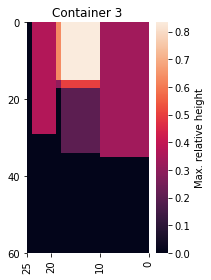

In [52]:
import seaborn as sns;

curr_containers = env.containers[0,2]
flat_trucks = np.sum(abs(curr_containers), axis=0) * 1.0 / 30


fig = plt.figure(figsize=(3, 4))
g = sns.heatmap(flat_trucks.T, cbar_kws={'label': 'Max. relative height'})
plt.title("Container 3")
#g.invert_yaxis()
g.invert_xaxis()
y = [0, 20, 40, 60]
x = [0, 10, 20, 25]
g.set_xticks(x)
g.set_xticklabels(x)
g.set_yticks(y)
g.set_yticklabels(y)

plt.tight_layout()


fig.savefig("../src/instance_plots/twod.pdf")
plt.show()

In [ ]:
_ = env.render_container(
        batch = 0,
        n_container = 2,
        fig_name=fig_name,
        save_plt=False,
        show_plt=True,
    )

In [ ]:
env.containers[0,0].shape

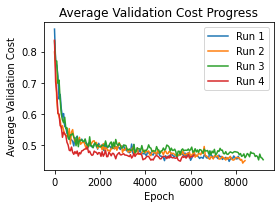

In [152]:
runs = ["run-EULER__novehpen_noforce__hwl_6512_seed_1_2021-09-11-08-43_graph15_batch100_lr0.0001-tag-val_cost_avg (1).csv",
        "run-EULER__novehpen_noforce__hwl_6512_seed_5_2021-09-11-08-43_graph15_batch100_lr0.0001-tag-val_cost_avg (1).csv",
        "run-EULER__novehpen_noforce__hwl_6512_seed_7_2021-09-11-08-43_graph15_batch100_lr0.0001-tag-val_cost_avg (1).csv",
        "run-EULER__nomix_fulldemand__hwl_6512_seed_51_2021-08-30-05-18_graph15_batch128_lr0.0001-tag-val_cost_avg (1).csv",
       ]

fig = plt.figure(figsize=(4, 3))
seeds = [1, 5, 7, 51]
seeds = [1, 2, 3, 4]
for run, seed in zip(runs, seeds):
    df = pd.read_csv(run)
    plt.plot(df["Step"], df["Value"], label = "Run "+ str(seed))

plt.title("Average Validation Cost Progress")
plt.ylabel("Average Validation Cost")
plt.xlabel("Epoch")
#plt.xlim(-200,6500)
plt.legend()
plt.tight_layout()
fig.savefig("../src/instance_plots/val.pdf")

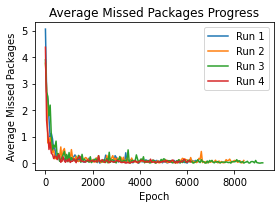

In [153]:
runs = ["run-EULER__novehpen_noforce__hwl_6512_seed_1_2021-09-11-08-43_graph15_batch100_lr0.0001-tag-val_model_missed_avg (1).csv",
        "run-EULER__novehpen_noforce__hwl_6512_seed_5_2021-09-11-08-43_graph15_batch100_lr0.0001-tag-val_model_missed_avg (1).csv",
        "run-EULER__novehpen_noforce__hwl_6512_seed_7_2021-09-11-08-43_graph15_batch100_lr0.0001-tag-val_model_missed_avg (1).csv",
        "run-EULER__nomix_fulldemand__hwl_6512_seed_51_2021-08-30-05-18_graph15_batch128_lr0.0001-tag-val_model_missed_avg (1).csv",
       ]
fig = plt.figure(figsize=(4, 3))
seeds = [1, 5, 7, 51]
seeds = [1, 2, 3, 4]
for run, seed in zip(runs, seeds):
    df = pd.read_csv(run)
    plt.plot(df["Step"], df["Value"], label = "Run "+ str(seed))

plt.title("Average Missed Packages Progress")
plt.ylabel("Average Missed Packages")
plt.xlabel("Epoch")
#plt.xlim(-200,6500)
plt.legend()
plt.tight_layout()
fig.savefig("../src/instance_plots/pack.pdf")